In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


%matplotlib inline

In [2]:
PATH_TO_FILE = '../data/heart_cleveland_upload.csv'
data = pd.read_csv(PATH_TO_FILE)
data.rename(columns={'condition':'target'}, inplace=True)
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
5,64,1,0,170,227,0,2,155,0,0.6,1,0,2,0
6,63,1,0,145,233,1,2,150,0,2.3,2,0,1,0
7,61,1,0,134,234,0,0,145,0,2.6,1,2,0,1
8,60,0,0,150,240,0,0,171,0,0.9,0,0,0,0
9,59,1,0,178,270,0,2,145,0,4.2,2,0,2,0


# EDA

Расшифрока данных взята отсюда: https://www.kaggle.com/code/shubamsumbria/heart-disease-dataset-cleveland-eda

- age: age in years

- sex: 1 = male; 0 = female

- cp: chest pain type: typical angina, atypical angina, non-anginal pain, asymptomatic

- trestbps: resting blood pressure (in mm Hg on admission to the hospital)

- chol: serum cholestoral in mg/dl

- fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

- restecg: resting electrocardiographic results: normal, having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), showing probable or definite left ventricular hypertrophy by Estes’ criteria

- thalach: maximum heart rate achieved

- exang: exercise induced angina (1 = yes; 0 = no)

- oldpeak: ST depression induced by exercise relative to rest

- slope: the slope of the peak exercise ST segment: upsloping, flat, downsloping

- ca: number of major vessels (0-3) colored by flourosopy

- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [3]:
print("Длина датасета:", len(data))
print(data.count())

Длина датасета: 297
age         297
sex         297
cp          297
trestbps    297
chol        297
fbs         297
restecg     297
thalach     297
exang       297
oldpeak     297
slope       297
ca          297
thal        297
target      297
dtype: int64


В датасете нет пропусков и неопределенных значений

In [4]:
dfx = data.drop(columns=["sex","target"])
dfx.describe()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017
std,9.049736,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000
75%,61.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000
max,77.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000


In [5]:
len(data[data["target"] == 0]), len(data[data["target"] == 1])

(160, 137)

классы 0 и 1 сбалансированы (количество больных и здоровых)

(14.5, -0.5)

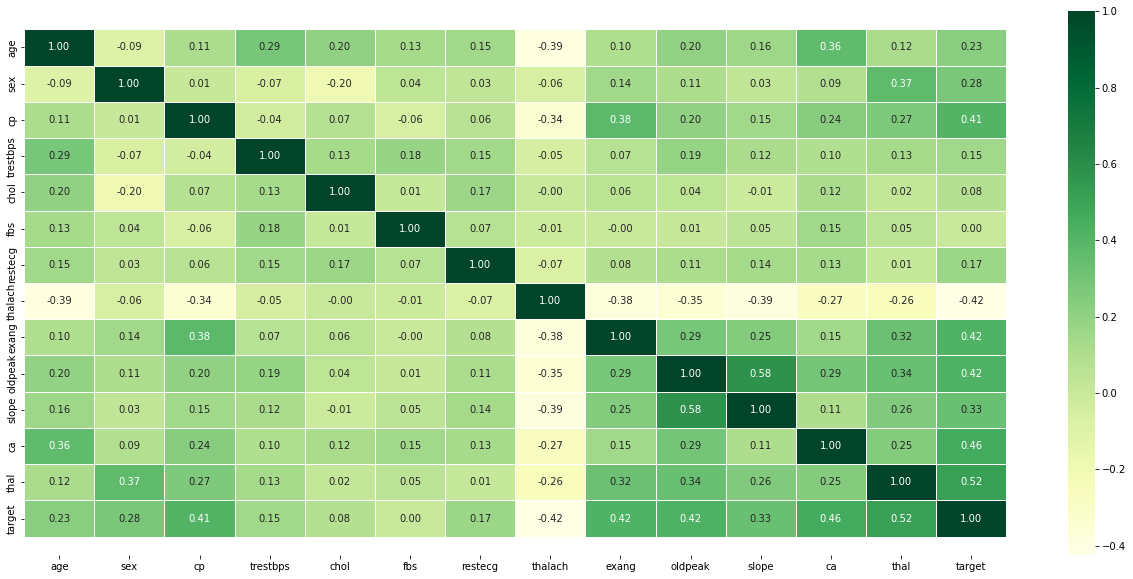

In [6]:
# Матрица корреляций
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(22, 10))
ax = sns.heatmap(corr_matrix,annot=True,linewidths=0.5,fmt=".2f",cmap="YlGn");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Видим хорошие корреляции с таргетной колонкой у всех колонок кроме fbs, chol (возможно их можно выкинуть).

In [7]:
categorical_val = []
continous_val = []
for column in data.columns:
    print('-------------------------------')
    print(f"{column} : {data[column].unique()}")
    if len(data[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

-------------------------------
age : [69 66 65 64 63 61 60 59 58 56 52 51 45 42 40 38 34 74 71 70 62 57 55 54
 50 49 48 46 44 41 35 29 76 68 67 53 47 43 39 37 77]
-------------------------------
sex : [1 0]
-------------------------------
cp : [0 1 2 3]
-------------------------------
trestbps : [160 140 150 138 110 170 145 134 178 120 118 152 125 148 156 128 136 130
 124 154 135 132 108 192 101 105 112 126 122 180 115 146 155 102 172 100
  94 129 142 144 106 117 158 174 164 114 165 200 123 104]
-------------------------------
chol : [234 239 226 282 211 227 233 240 270 288 273 204 283 193 186 298 213 264
 244 199 231 182 269 302 245 246 195 281 208 221 284 319 236 261 232 294
 250 262 342 309 325 201 205 271 266 229 197 160 308 263 219 220 295 203
 198 235 306 157 192 210 265 254 274 277 564 212 278 417 360 335 313 252
 243 185 318 178 218 230 224 340 168 126 256 258 214 304 267 196 222 175
 188 149 275 255 257 253 177 141 242 315 209 180 268 321 215 174 322 286
 299 237 223 228 225 

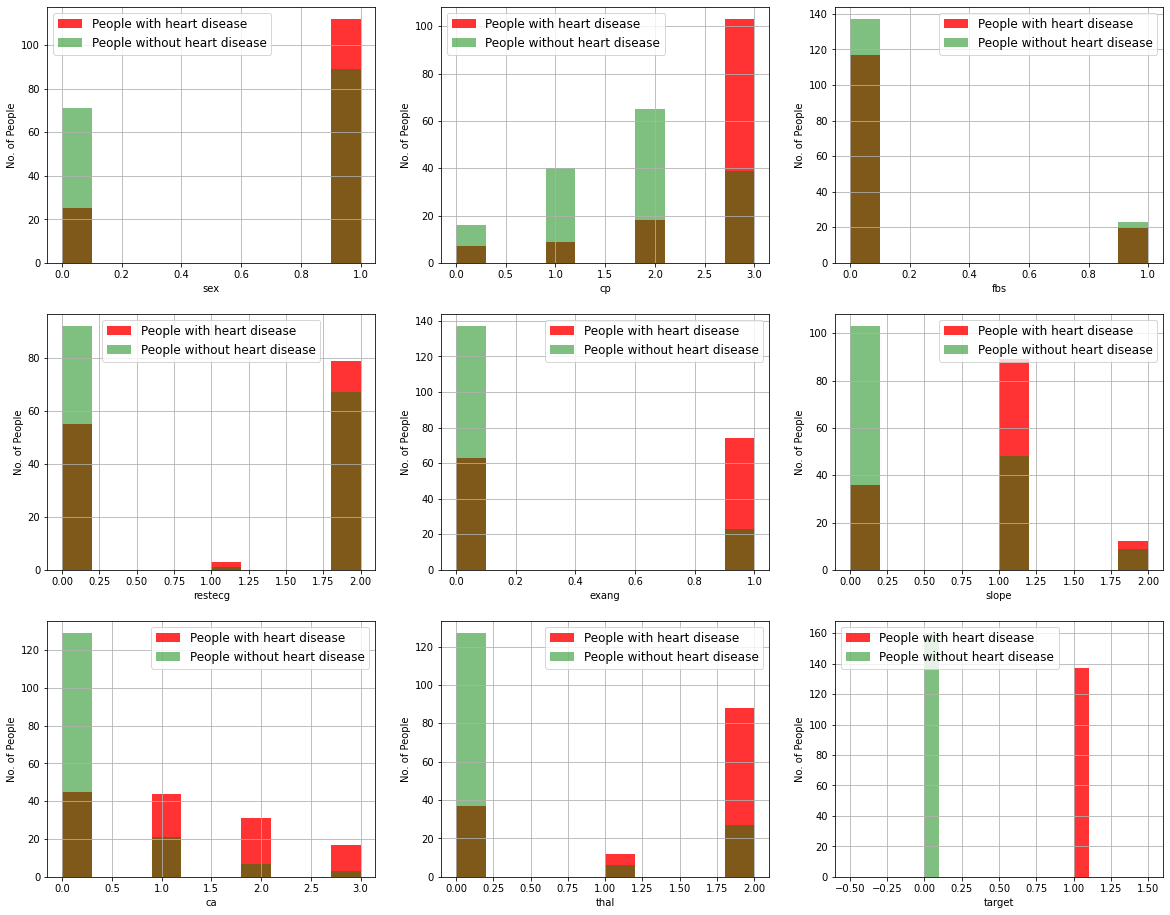

In [8]:
# гистограммы категориальных признаков
plt.figure(figsize=(20, 16))
for i, column in enumerate(categorical_val, 1):
    plt.subplot(3, 3, i)
    data[data["target"] == 1][column].hist(bins=10, color='red',
                                           label='People with heart disease',alpha=0.8)
    data[data["target"] == 0][column].hist(bins=10, color='green',
                                           label='People without heart disease',alpha=0.5)
    plt.legend(fontsize=12)
    plt.xlabel(column)
    plt.ylabel("No. of People")

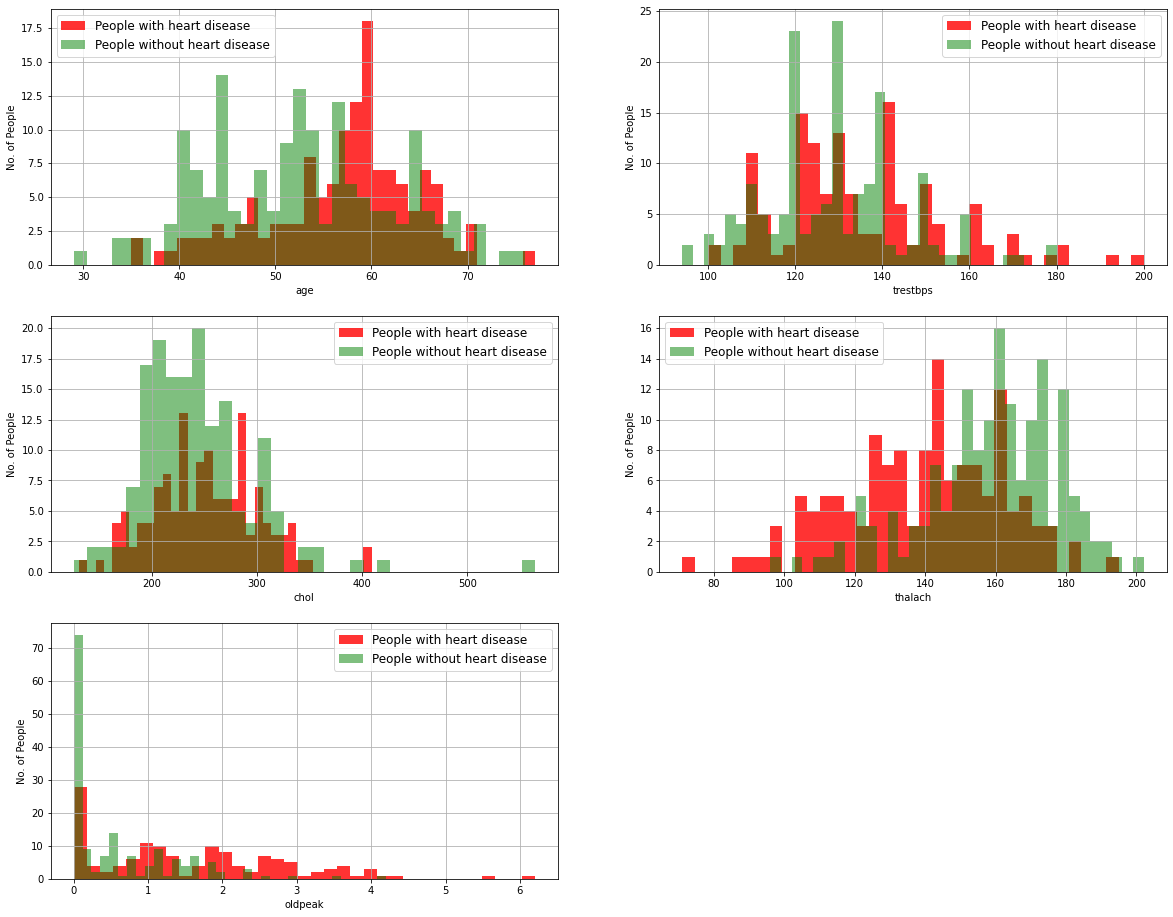

In [9]:
# гистограммы непрерывных признаков
plt.figure(figsize=(20, 16))
for i, column in enumerate(continous_val, 1):
    plt.subplot(3, 2, i)
    data[data["target"] == 1][column].hist(bins=35, color='red',
                                           label='People with heart disease', alpha=0.8)
    data[data["target"] == 0][column].hist(bins=35, color='green',
                                           label='People without heart disease',alpha=0.5)
    plt.legend(fontsize=12)
    plt.xlabel(column)
    plt.ylabel("No. of People")

## Выводы из EDA:
- по категориальным признакам все нормально, может какие-то аномалии только убрать
- по непрерывным переменным oldpeak можно перевести в log scale

<AxesSubplot:>

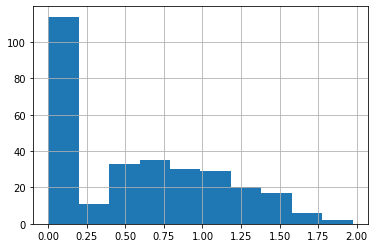

In [10]:
data['oldpeak'].apply(lambda x: np.log(1 + x)).hist()

# MODEL training & testing

Попробуем линейную модель и градиентный бустинг

In [11]:
y = data['target']
X = data.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
clf = GradientBoostingClassifier(n_estimators=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [13]:
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.797979797979798, 0.782608695652174, 0.8025332225913622)

Для линейной модели нужно закодировать категориальные признаки и отмасштабировать непрерывные признаки

In [14]:
def one_hot_encoding_by_column(data, column):
    one_hot = pd.get_dummies(data[column], prefix=column)
    data = data.drop(column, axis=1)
    data = data.join(one_hot)
    return data

In [15]:
X_train_preprocessed = X_train
X_test_preprocessed = X_test
for column in categorical_val[:-1]:
    X_train_preprocessed = one_hot_encoding_by_column(X_train_preprocessed, column)
    X_test_preprocessed = one_hot_encoding_by_column(X_test_preprocessed, column)

In [16]:
X_train_preprocessed['oldpeak'] = X_train_preprocessed['oldpeak'].apply(lambda x: np.log(1 + x))
X_test_preprocessed['oldpeak'] = X_test_preprocessed['oldpeak'].apply(lambda x: np.log(1 + x))

In [17]:
# calculate mean and std in X_train_preprocessed in continuous features

In [18]:
mean_columns = {}
std_columns = {}
for column in continous_val:
    mean_columns[column] = np.mean(X_train_preprocessed[column])
    std_columns[column] = np.std(X_train_preprocessed[column])

In [19]:
# normalizing
for column in continous_val:
    X_train_preprocessed[column] = X_train_preprocessed[column].apply(
        lambda x: (x - mean_columns[column]) / (std_columns[column] + 1e-8)
    )
    X_test_preprocessed[column] = X_test_preprocessed[column].apply(
        lambda x: (x - mean_columns[column]) / (std_columns[column] + 1e-8)
    )

In [20]:
clf = LogisticRegression(C=1)
clf.fit(X_train_preprocessed, y_train)
y_pred = clf.predict(X_test_preprocessed)

In [21]:
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.8282828282828283, 0.8172043010752689, 0.834717607973422)

In [22]:
# Вывод: берем логистическую регрессию как основную модель